In [28]:
import sys
!{sys.executable} -m pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.7/454.7 kB 12.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 193.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 348.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.24.4
    Uninstalling protobuf-4.24.4:
      Successfully uninstalled protobuf-4.24.4

[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [29]:
import boto3
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tf2onnx
import onnx


In [13]:

s3_client = boto3.client('s3')
response = s3_client.get_object(Bucket="gmidha-bigdata-oct26", Key="msft2d.csv")

status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")

if status == 200:
    print(f"Successful S3 get_object response. Status - {status}")
    msft_df = pd.read_csv(response.get("Body"))
    print(msft_df)
else:
    print(f"Unsuccessful S3 get_object response. Status - {status}")

Successful S3 get_object response. Status - 200
       tradedate   close    volume    open    high     low
0     2018-08-30  111.95  22759640  111.67  112.61  111.44
1     2018-08-31  112.33  23217310  111.69  112.78  111.52
2     2018-09-04  111.71  22558040  110.85  111.96  110.22
3     2018-09-05  108.49  32838650  111.01  111.42  108.10
4     2018-09-06  108.74  23226430  108.25  108.99  107.51
...          ...     ...       ...     ...     ...     ...
1252  2023-08-23  327.00  21166380  323.82  329.20  323.46
1253  2023-08-24  319.97  23281430  332.85  332.98  319.96
1254  2023-08-25  322.98  21684100  321.47  325.36  318.80
1255  2023-08-28  323.70  14808480  325.66  326.15  321.72
1256  2023-08-29  328.41  19284590  321.88  328.98  321.88

[1257 rows x 6 columns]


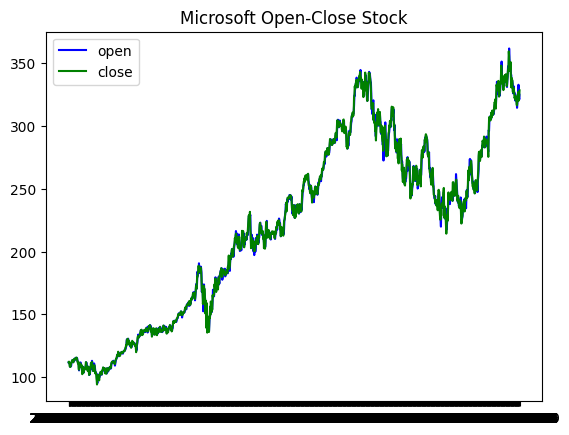

In [14]:
plt.plot(msft_df['tradedate'],msft_df['open'],color="blue",label="open")
plt.plot(msft_df['tradedate'],msft_df['close'],color="green", label="close")
plt.title("Microsoft Open-Close Stock")
plt.legend()

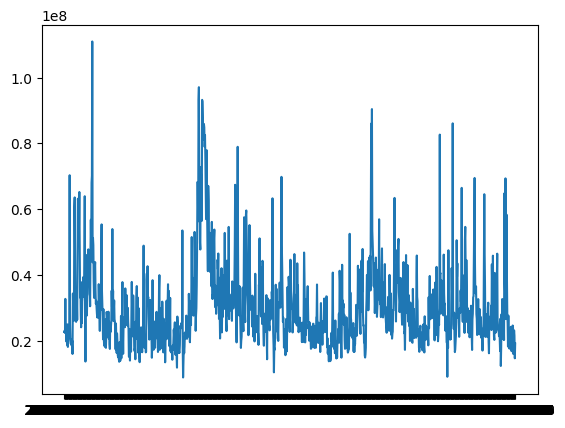

In [17]:
plt.plot(msft_df['tradedate'],msft_df['volume'])
plt.show()

In [20]:
close_data = msft_df.filter(['close'])
dataset = close_data.values
training = int(np.ceil(len(dataset) * .7))
print(training)

880


In [21]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
 
train_data = scaled_data[0:int(training), :]

# prepare feature and labels
x_train = []
y_train = []
 
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
 
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [22]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64,
                            return_sequences=True,
                            input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))
model.summary

<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x7f26ff58fe20>>

In [23]:
model.compile(optimizer='adam',
              loss='mean_squared_error')
history = model.fit(x_train,
                    y_train,
                    epochs=10)

Epoch 1/10
26/26 [==============================] - 3s 33ms/step - loss: 0.0328
Epoch 2/10
26/26 [==============================] - 1s 33ms/step - loss: 0.0099
Epoch 3/10
26/26 [==============================] - 1s 33ms/step - loss: 0.0088
Epoch 4/10
26/26 [==============================] - 1s 32ms/step - loss: 0.0080
Epoch 5/10
26/26 [==============================] - 1s 32ms/step - loss: 0.0088
Epoch 6/10
26/26 [==============================] - 1s 33ms/step - loss: 0.0078
Epoch 7/10
26/26 [==============================] - 1s 32ms/step - loss: 0.0075
Epoch 8/10
26/26 [==============================] - 1s 32ms/step - loss: 0.0077
Epoch 9/10
26/26 [==============================] - 1s 32ms/step - loss: 0.0083
Epoch 10/10
26/26 [==============================] - 1s 32ms/step - loss: 0.0066


In [24]:
test_data = scaled_data[training - 60:, :]
x_test = []
y_test = dataset[training:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
 
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
 
# predict the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
 
# evaluation metrics
mse = np.mean(((predictions - y_test) ** 2))
print("MSE", mse)
print("RMSE", np.sqrt(mse))

12/12 [==============================] - 1s 8ms/step
MSE 114.81588470631947
RMSE 10.715217436259493


/tmp/ipykernel_88/1495850198.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


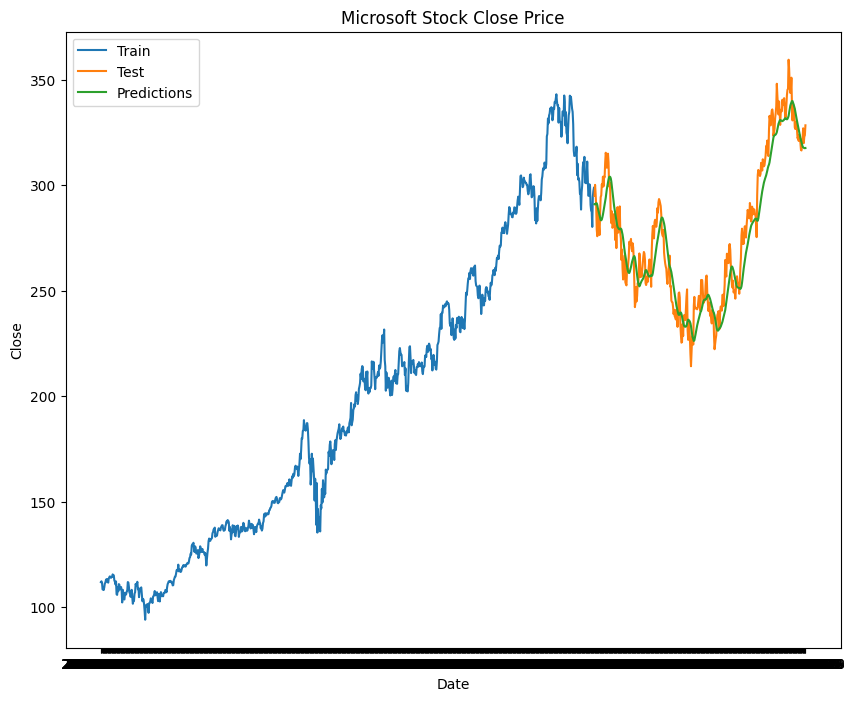

In [26]:
train = msft_df[:training]
test = msft_df[training:]
test['Predictions'] = predictions
 
plt.figure(figsize=(10, 8))
plt.plot(train['tradedate'], train['close'])
plt.plot(test['tradedate'], test[['close', 'Predictions']])
plt.title('Microsoft Stock Close Price')
plt.xlabel('Date')
plt.ylabel("Close")
plt.legend(['Train', 'Test', 'Predictions'])

In [34]:
model.save("/opt/app-root/src/rhods-deploy/model.keras")
#onnx_model = tf2onnx.convert.from_keras(model, opset=13)
#onnx.save(onnx_model, "/model.onnx")